<img src='https://s3.amazonaws.com/drivendata.org/kif-example/img/dd.png' style="width:100%"/>

# Our Naïve Bees Classifier

We're excited to [launch a new comeptition](http://www.drivendata.org/competitions/8/) with our partner [Metis](http://thisismetis.com). If you're not sure what we're talking about, head to:

### [The Competition Homepage](http://www.drivendata.org/competitions/8/)

The question at hand is: can you identify a bee as a honey bee or a bumble bee? These bees have different [behaviors and appearances](http://bumblebeeconservation.org/about-bees/faqs/honeybees-vs-bumblebees/), but given the variety of backgrounds, positions, and image resolutions it can be a challenge for machines to tell them apart. You can win part of the **$5,000** prize pool by competing!

Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like [colony collapse disorder](http://news.harvard.edu/gazette/story/2015/07/pesticide-found-in-70-percent-of-massachusetts-honey-samples/) threaten these species.

Here, we'll walk through what a first-pass approach to this question could look like. We'll use relatively simple features and models to show that even without GPU computing and neural nets, we can start to answer this question. 

### This notebook contains three sections:

 - [Loading the data](#digging)
 - [Creating image features](#features)
 - [Fitting a model](#model)
 - [Submitting the predictions](#predictions)

We'll get started by loading the python modules in our analysis toolkit.

In [1]:
import os
from tqdm import tqdm # smart progress bar


# ================  GRAPHICS
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc_params
 
# get our styles
mpl_default = rc_params()
 
import seaborn as sns
sns.set(rc=mpl_default)
 
%matplotlib inline
plt.rcParams = mpl_default

# ================  NUMBERS AND MATHS AND THINGS
import pandas as pd
import numpy as np

# BEES colormap! Black -> Yellow
CMAP = [(0,0,0),
        (22,0,0),
        (43,0,0),
        (77,14,0),
        (149,68,0),
        (220,123,0),
        (255,165,0),
        (255,192,0),
        (255,220,0),
        (255,235,0),
        (255,245,0),
        (255,255,0)]


bees_cm = mpl.colors.ListedColormap(np.array(CMAP)/255.)

<a id="digging"></a>

# Load the data

The first step is to look at the files we downloaded from the competition webpage and load the training labels and submission format. The data for this competition is very simple. It's a set of training and test images, and then a set of labels for the training images. The submission format has a placeholder for your predictions. As noted on the [problem description page](http://www.drivendata.org/competitions/8/page/31/), a prediction of `1.0` means you are sure that the bee pictured is a *Bombus*. A prediction of `0.0` means that you are sure it's an *Apis*. A prediction of `0.5` means you don't know which it is.

In [2]:
# list the contents of the data directory
!tree --filelimit=10 data/

data/
├── SubmissionFormat.csv
├── images
│   ├── test [992 entries exceeds filelimit, not opening dir]
│   └── train [3969 entries exceeds filelimit, not opening dir]
└── train_labels.csv

3 directories, 2 files


In [3]:
# load the labels using pandas
labels = pd.read_csv("data/train_labels.csv",
                     index_col=0)

submission_format = pd.read_csv("data/SubmissionFormat.csv",
                                index_col=0)

print "Number of training examples is: ", labels.shape[0]
print "Predictions should be type:", labels.dtypes[0]
labels.head()

Number of training examples is:  3969
Predictions should be type: float64


,genus
id,
520,1
3800,1
3289,1
2695,1
4922,1


In [4]:
# let's see what's in one of the image folders
!ls data/images/train/ | head -n 10

1.jpg
100.jpg
1000.jpg
1002.jpg
1003.jpg
1004.jpg
1007.jpg
1008.jpg
1009.jpg
1010.jpg


We can see that the image file names match the `id` in `labels` and `submission_format`. This is how we match an image to whether the bee is an *Apis* or *Bombus*.

Ok, finally, let's look at some bees. The PIL library (we recommend the [Pillow fork](https://pillow.readthedocs.org/)) is a great way to interact with images in Python. We'll use PIL for accessing images, but do most of our processing by converting the images to [Numpy](http://www.numpy.org/) arrays. Also, note that all of the images are the same size (200x200 px), which we've done to make your lives easier.

In [7]:
def get_image(row_or_str, root="data/images/"):
    # if we have an instance from the data frame, pull out the id
    # otherwise, it is a string for the image id
    if isinstance(row_or_str, pd.core.series.Series):
        row_id = row_or_str.name
    else:
        row_id = row_or_str
    
    filename = "{}.jpg".format(row_id)
    
    # test both of these so we don't have to specify. Image should be
    # in one of these two. If not, we let Image.open raise an exception.
    train_path = os.path.join(root, "train", filename)
    test_path = os.path.join(root, "test", filename)
    
    file_path = train_path if os.path.exists(train_path) else test_path
    
    return np.array(Image.open(file_path), dtype=np.int32)
        

# make sure it works for strings and series
assert (get_image(labels.iloc[0]) == get_image("520")).all()

# confirm images are the same shape
print "Size of image 520:  ", get_image("520").shape
print "Size of image 1001: ", get_image("1001").shape

Size of image 520:   (200, 200, 3)
Size of image 1001:  (200, 200, 3)


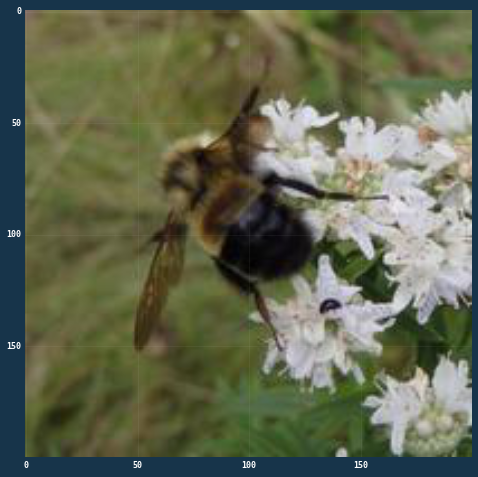

In [8]:
# imshow expects floats between 0-1, but we have
# integers 0-255 from PIL so we need to rescale to view the image
plt.imshow((get_image("520") / 255.))

<a id="features"></a>

# Build features from the image

Now we need to turn these images into something that a machine learning algorithm can understand. We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them.

We'll be building three kinds of features:
 * Information about the colors present in the image (note the *Apis* and *Bombus* have different colorings)
 * [Histogram of oriented gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)
 * [DAISY feature descriptors](http://infoscience.epfl.ch/record/138785/files/tola_daisy_pami_1.pdf)
 
First, we'll start by extracting the color information since both HOG and DAISY work on grayscale images.

array([ 201.,  194.,  127., ...,  179.,  177.,  171.])

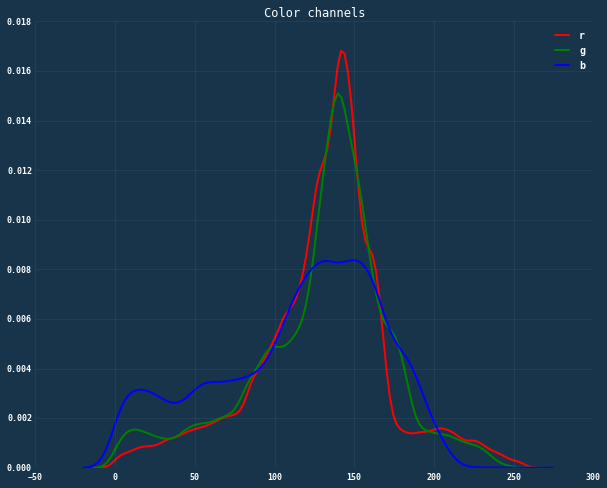

In [22]:
def extract_rgb_info(rgb, ax=None):
    """Extract color statistics as features:
        - pixel values (flattened)
        - X, Y sums per channel
        - percentiles per channel
        - percentile diffs per channel

        Plots if ax is passed
    """
    # toss alpha if it exists
    if rgb.shape[2] == 4:
        rgb = rgb[:, :, :3]

    # start with raw pixel values as features
    features = [rgb.flatten()]

    # add some basic statistics on the color channels (R, G, B)
    for channel in range(3):
        this_channel = rgb[:, :, channel].astype(np.float)
        sums = np.hstack([this_channel.sum(),
                          this_channel.sum(axis=0),
                          this_channel.sum(axis=1)])

        # percentiles
        ps = [1, 3, 5, 10, 50, 90, 95, 97, 99]
        percentiles = np.array(np.percentile(this_channel, ps))
        diff = percentiles[-4:] - percentiles[:4]
        
        # plot if we have been passed an axis
        if ax is not None:
            channel_name = ['r', 'g', 'b'][channel]       
            sns.kdeplot(this_channel.flatten(),
                        ax=ax,
                        label=channel_name,
                        color=channel_name)
            ax.set_title("Color channels")

        
        # store the features for this channel
        features += [sums, percentiles, diff]
        
    # return all the color features as a flat array
    return np.hstack(features).flatten()

extract_rgb_info(get_image("1974"), ax=plt.gca())

Now we can build a big matrix that includes the raw pixel values, our extracted color information, and the HOG and DAISY feature descriptors. Lucky for us, there are great implementations of HOG and DAISY in the [`skimage`](http://scikit-image.org/) package. They're also available as part of the most robust free computer vision library, [OpenCV](). OpenCV also has some very good [Python tutorials](http://docs.opencv.org/3.0.0/d6/d00/tutorial_py_root.html), if you want to get started. However, the setup is just a bit more arduous than `pip install scikit-image`.

We'll create a function, `preprocess`, that will load an image and generate a flat array for all of the features we care about. Also, completely for free, I've included a `demo` paramater that will plot a pretty image of all of the features that we're constructing.

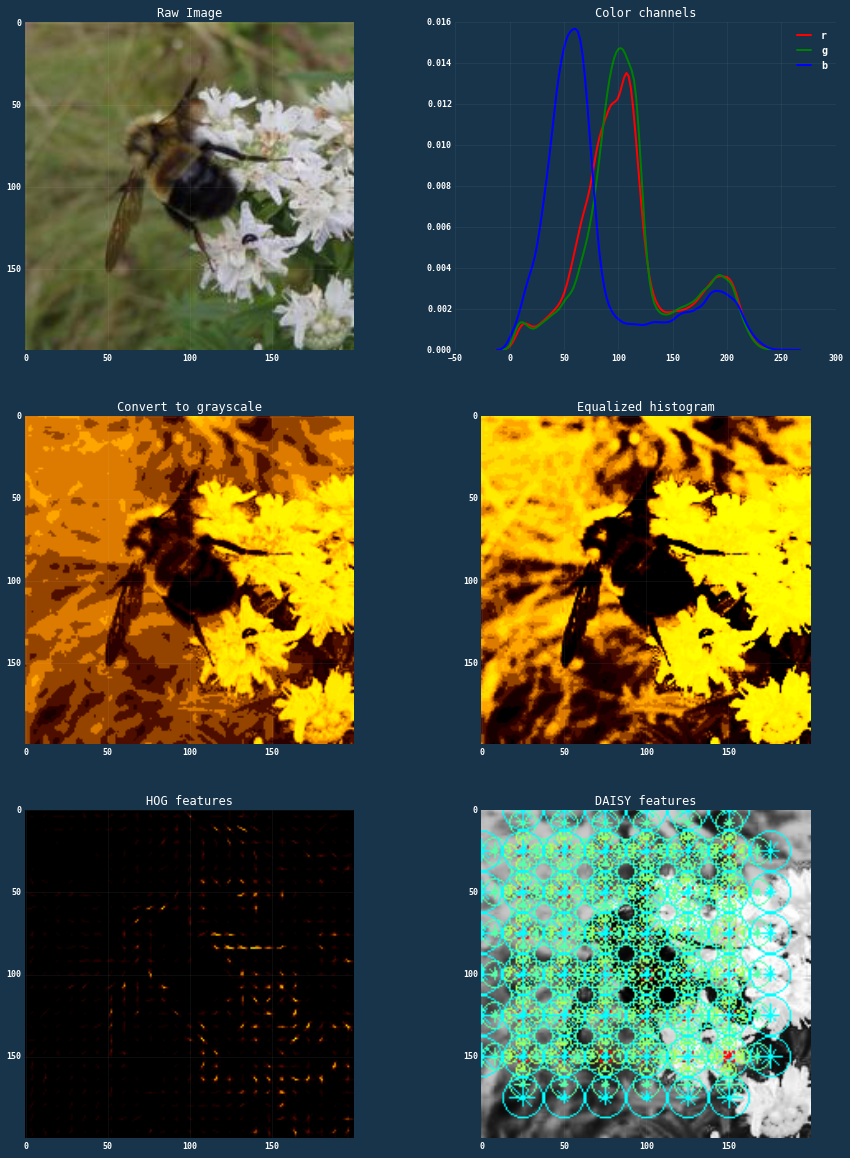

In [23]:
from skimage.feature import daisy
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

def preprocess(img, demo=False):
    """ Turn raw pixel values into features.
    """
    
    def _demo_plot(img, stage="", is_ints=False, axes_idx=0):
        """ Utility to visualize the features we're building
        """
        if demo:
            axes[axes_idx].imshow(img / 255. if is_ints else img,
                                  cmap=bees_cm)
            axes[axes_idx].set_title(stage)
        return axes_idx + 1

    if demo:
        fig, axes = plt.subplots(3, 2, figsize=(15, 20))
        axes = axes.flatten()
    
    # track which subplot we're plotting to
    axes_idx = 0
    axes_idx = _demo_plot(img, stage="Raw Image", is_ints=True, axes_idx=axes_idx)
        
    # FEATURE 1: Raw image and color data    
    if demo:
        color_info = extract_rgb_info(img, ax=axes[axes_idx])
        axes_idx += 1
    else:
        color_info = extract_rgb_info(img)
    
    # remove color information (hog and daisy only work on grayscale)
    gray = rgb2gray(img)
    axes_idx = _demo_plot(gray, stage="Convert to grayscale", axes_idx=axes_idx)
    
    # equalize the image
    gray = equalize_hist(gray)
    axes_idx = _demo_plot(gray, stage="Equalized histogram", axes_idx=axes_idx)
    
    # FEATURE 2: histogram of oriented gradients features
    hog_features = hog(gray,
                       orientations=12,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(1, 1),
                       visualise=demo)
    
    # if demo, we actually got a tuple back; unpack it and plot
    if demo:
        hog_features, hog_image = hog_features
        axes_idx = _demo_plot(hog_image, stage="HOG features", axes_idx=axes_idx)
        
    # FEATURE 3: DAISY features - sparser for demo so can be visualized
    params = {'step': 25, 'radius': 25, 'rings': 3} if demo \
             else {'step': 10, 'radius': 15, 'rings': 4}
    daisy_features = daisy(gray,
                           histograms=4,
                           orientations=8,
                           normalization='l1',
                           visualize=demo,
                           **params)
        
    if demo:
        daisy_features, daisy_image = daisy_features
        axes_idx = _demo_plot(daisy_image, stage="DAISY features", axes_idx=axes_idx)
    
    # return a flat array of the raw, hog and daisy features
    return np.hstack([color_info, hog_features, daisy_features.flatten()])


preprocess_result = preprocess(get_image("520"), demo=True)

Ooo! It's so pretty! But, now it's time to really get down to business. We need to turn all of our thousands of images into a **BIG DATA MATRIX** (Ok, not really big data. But, it is a big-ish matrix).

Also, now is a good chance to give a shout-out to the best tiny Python package that I have found in a while, [tqdm](https://github.com/tqdm/tqdm). Stop writing counters with modulos to track long-running for-loops. Just wrap the iterator after the `in` in a call to `tqdm()`, and you magically get a progress bar. It's the perfect way to know if you have time to grab coffee.

In [24]:
def create_feature_matrix(label_dataframe):
    n_imgs = label_dataframe.shape[0]
    
    # initialized after first call to 
    feature_matrix = None
    
    for i, img_id in tqdm(enumerate(label_dataframe.index)):
        features = preprocess(get_image(img_id))
        
        # initialize the results matrix if we need to
        # this is so n_features can change as preprocess changes
        if feature_matrix is None:
            n_features = features.shape[0]
            feature_matrix = np.zeros((n_imgs, n_features), dtype=np.float32)
            
        if not features.shape[0] == n_features:
            print "Error on image {}".format(img_id)
            features = features[:n_features]
        
        feature_matrix[i, :] = features
        
    return feature_matrix

# turn those images into features!
bees_features = create_feature_matrix(labels)

# save in case we need to load later; creating this takes
# a little while and it ends up being ~3GBs
np.save("bees_features.npy", bees_features)

In [11]:
bees_features = np.load("bees_features.npy")

Our features aren't quite done yet. Many machine learning methods are built to work best with data that has a mean of 0 and unit variance. Luckily, `scikit-learn` [provides a simple way](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to rescale your data to work well. They've got a more thorough explanation of why that is the linked docs.

In [34]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
bees_stand = ss.fit_transform(bees_features)
bees_stand.shape

(3969, 168046)

<a id="model"></a>

# Modeling using SVMs

Ok, now let's build our benchmark model. We partly chose SVMs because they are a popular method that we haven't covered before, and we partly chose them because it's easy to test both linear and non-linear classifiers with an SVM. Given that we've generated a huge number of features and (somewhat arbitrarily) decided to use an SVM, it may make you sad to see in the [sklearn docs](http://scikit-learn.org/stable/modules/svm.html):

>If the number of features is much greater than the number of samples, the method is likely to give poor performances.

So, let's reduce the number of features that we have. One way to select features, is to perform [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis). We'll aim to have an approximately square feature matrix by keeping 4,000 components.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4e3)
bees_pca = pca.fit_transform(bees_stand)

Remember that [New York Times article about "data janitors"](http://www.nytimes.com/2014/08/18/technology/for-big-data-scientists-hurdle-to-insights-is-janitor-work.html)? It feels pretty real. We've spent 80% of our time cleaning and setting up our problem. And now, finally, we're getting to the model building.

First, we break the data into a local train/test split. Then, we use one of sklearn's killer features, `GridSearchCV`. The grid search allows us to  to search over a set of possible parameters all at once (without manually tweaking and remembering the outcomes). For the SVM, we vary the `C` and `gamma` parameters--`C` controls the cost of misclassifying a particular image; `gamma` is a kernel parameter that [defines the influence of any given point](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). For all of the possible parameters one could search, check out the [SVC docs](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [36]:
from sklearn import svm

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# split into a local train/test set
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.2,
                                                    random_state=1234123)

# SVM parameters often set on log scale
params_to_try = {
    'C': [10**i for i in range(0, 2)],
    'gamma': [10**i for i in range(-7, -5)],
}

gs = GridSearchCV(svm.SVC(class_weight='auto', kernel='rbf', probability=True),
                  param_grid=params_to_try,
                  cv=3,
                  scoring='roc_auc',
                  n_jobs=-1)

gs.fit(X_train, y_train)

print "Best parameters:", gs.best_params_
print "Best score:", gs.best_score_

Best parameters: {'C': 1, 'gamma': 1e-06}
Best score: 0.678907848193


Now we'll take the best performing model and make probability predictions on our local holdout set.

In [18]:
preds = gs.best_estimator_.predict_proba(X_test)

We can score and plot our predictions using the competition metric, [AUROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), to see how well our best model performs on this local holdout set.

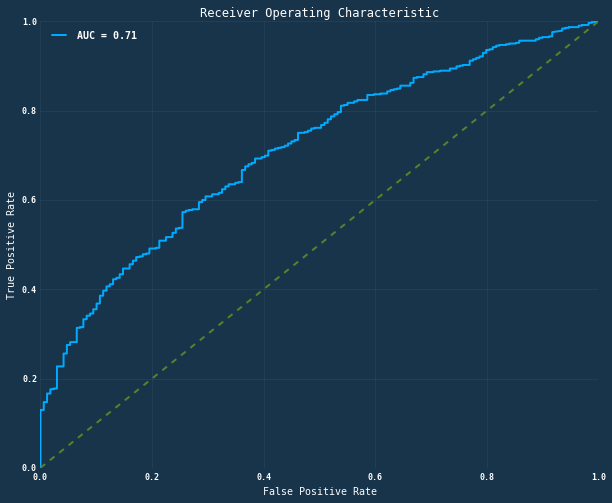

In [20]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,
                                                                preds[:, 1],
                                                                pos_label=1)

roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,
         true_positive_rate,
         label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Great! So we're getting about a 0.7 AUC from this model. That's a good start, but there's a lot of room to improve. In general, models with an AUC of 0.5 have no predictive power (that's the dotted green line) and models with perfect class separation have an AUC of 1.0.

The last thing we'll do is run the competition test set through our entire pipeline and [make our submission on the DrivenData platform](http://www.drivendata.org/competitions/8/submissions/).

In [29]:
sf = pd.read_csv("data/SubmissionFormat.csv", index_col=0)

def make_predictions(submission_format_df,output_filepath="my_submission.csv"):
    prediction_df = submission_format_df.copy()
    
    # create features
    test_features = create_feature_matrix(submission_format_df)
    test_features_stand = ss.transform(test_features)   
    test_features_pca = pca.transform(test_features_stand)
    
    # predict with the best estimator from the grid search
    preds = gs.best_estimator_.predict_proba(test_features_pca)
    
    # copy the predictions to the dataframe with the ids and
    # write it out to a file
    prediction_df.genus = preds[:, 1]
    prediction_df.to_csv(output_filepath)
    
    return prediction_df
    
pred_df = make_predictions(sf, output_filepath="raw_hog_daisy_rbf.csv")
pred_df.head()

,genus
id,
2783,0.847273
2175,0.875663
4517,0.879757
2831,0.732987
3556,0.828222


<img src="https://s3.amazonaws.com/drivendata.org/bees-example/ss.png"></img>

Yay! We can see that our cross-validation and holdout scores were pretty reliable in this case. Now it's up to you to [**make the performance even better**](http://www.drivendata.org/competitions/8/)!

<p><div class="well" align="center">
<a href="http://www.drivendata.org"><img src='https://s3.amazonaws.com/drivendata.org/kif-example/img/dd.png' style="width:100%"/></a>
<h1>[www.drivendata.org](http://www.drivendata.org)
</h1></div>

* Check out our <strong>[forum](http://community.drivendata.org/)</strong>
* Or, give us a shout out on twitter: **[@drivendataorg](https://twitter.com/drivendataorg)**
